In [1]:
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import random
import mpmath as mp
plt.style.use('default')
#myColor  = ("#E3072A","#0A8974","#5FAECC","#E49C23","#E27520") # Darjeeling Color map
myColor  = ("#E3072A","#0A8974","#5FAECC") # Darjeeling Color map

In [2]:
import HALS as hals

In [3]:
# Earth tide frequencies
et_fqs = {'Q1': 0.893244, 'O1': 0.929536, 'M1': 0.966446, 'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'N2': 1.895982, 'M2': 1.932274, 'S2': 2.0, 'K2': 2.005476}
# Atmospheric tide frquencies
at_fqs = {'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'S2': 2.0, 'K2': 2.005476}

In [4]:
folder = "test_data"
file = "J"
raw_data = pd.read_csv(folder + '/' + file + '_data.csv')
raw_data.iloc[0]

Datetime                01/01/2013 00:00
Atm. pressure [mbar]               900.5
J6 [m]                             16.11
J7 [m]                              9.78
JC [m]                             50.32
Volume strain                   1.216598
Name: 0, dtype: object

In [5]:
# search for a datetime column
dt_col = raw_data.columns[raw_data.columns.str.contains('datetime', case=False)][0]
# streamline the column format
raw_data[dt_col] = pd.to_datetime(raw_data[dt_col],dayfirst=True)

# create a numeric value column
dnum_col = pd.to_numeric(raw_data[dt_col])
dnum_col = (dnum_col-dnum_col[0])
dnum_col = dnum_col/ 10**9 # from ns to seconds
dnum_col = dnum_col/(60*60*24) # to days

raw_data.insert(0,"dnum",dnum_col)
raw_data.dnum

0            0.000000
1            0.041667
2            0.083333
3            0.125000
4            0.166667
             ...     
17512    91045.991167
17513    91045.991167
17514    91045.991167
17515    91045.991167
17516    91045.991167
Name: dnum, Length: 17517, dtype: float64

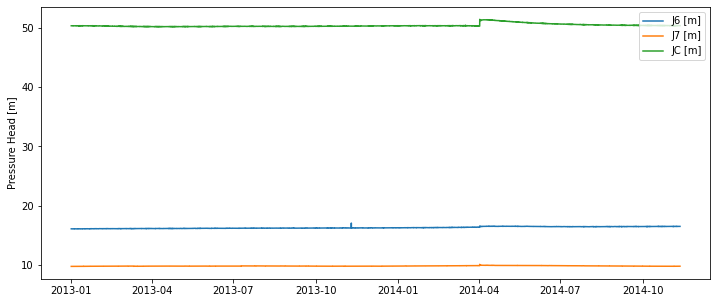

In [6]:
gw_col = list(raw_data.columns[raw_data.columns.str.contains('J', case=False)])
fig, ax = plt.subplots(nrows= 1,figsize=(12.0,5.0), sharex = True) # ,sharey=True
for name,i in zip(gw_col,range(len(gw_col))):
    gw = raw_data[name]
    # Groundwater Head Measurements    
    ax.plot(raw_data[dt_col],gw,label=name)
    ax.set_ylabel("Pressure Head [m]")
    ax.legend(loc="upper right")

In [7]:
timestart=0
timeend=30*24*(12+10)#(day*hour*month)
df_gaps=raw_data[timestart:timeend]

,dnum,J6 [m],J7 [m],JC [m]
0,0.000000,0.004755,0.001000,0.001322
1,0.041667,0.004996,0.000974,0.001718
2,0.083333,0.005237,0.000948,0.002114
3,0.125000,0.005478,0.000922,0.012509
4,0.166667,-0.004282,0.000896,0.002905
...,...,...,...,...
15835,659.791667,-0.005355,-0.000779,-0.015941
15836,659.833333,-0.005397,-0.001042,-0.005871
15837,659.875000,0.004561,0.008696,0.004199
15838,659.916667,0.004519,0.008433,0.014270


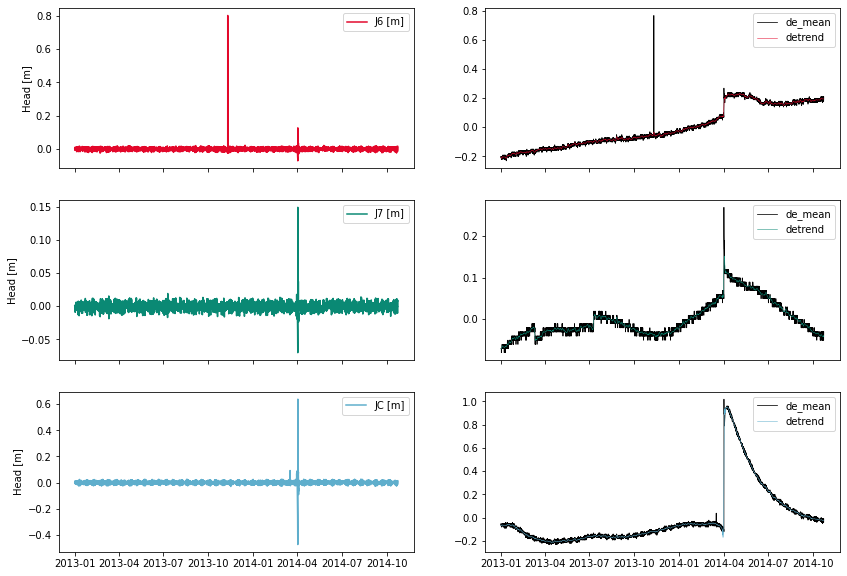

In [8]:
length = 3.0 # length of the detrend window
stopper = 3 # minimum number of samples in window
n_ovrlp = 5 # number of window overlaps

fig, ax = plt.subplots(nrows= len(gw_col),ncols=2,figsize=(14.0,10.0), sharex = True) # ,sharey=True
# create a new dataframe for the detrended data
df_detr = pd.DataFrame(df_gaps.dnum,columns = ["dnum"])
for name,i in zip(gw_col,range(len(gw_col))):
    gw = df_gaps[name]
    # detrending of the data
    df_detr[name] = hals.lin_window_ovrlp(df_gaps.dnum, gw.values,length=length,stopper=stopper,n_ovrlp=n_ovrlp)
    ax[i,0].plot(df_gaps[dt_col],df_detr[name], label = name, color=myColor[i])
    ax[i,0].legend()
    ax[i,0].set_ylabel("Head [m]")
    de_mean = gw.values - np.nanmean(gw.values)
    ax[i,1].plot(df_gaps[dt_col], de_mean, label='de_mean', lw=0.75,color="black")
    ax[i,1].plot(df_gaps[dt_col], de_mean - df_detr[name], label='detrend', lw=0.5, color=myColor[i])
    ax[i,1].legend(loc="upper right")
df_detr  

In [9]:
freqs = {**et_fqs, **at_fqs}

# create new dataframes for the amplitude and phase results
df_A = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])
df_phi = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])

# loop over the groundwater head measurement data sets
for name,i in zip(gw_col,range(len(gw_col))):
    gw = df_detr[name]
    #HALS function
    output = hals.hals_lsq(df_detr.dnum.values, gw.values, list(freqs.values()))
    df_A[name] = output[0] #Amplitudes
    df_phi[name] = output[1]*180/np.pi #Phases
    
df_A    

Conditioning number:  1.5717518260042265
Conditioning number:  1.5717518260042265
Conditioning number:  1.5717518260042265


,freqs,J6 [m],J7 [m],JC [m]
Q1,0.893244,0.000170,0.000099,0.000721
O1,0.929536,0.000936,0.000732,0.002416
M1,0.966446,0.000176,0.000052,0.000322
P1,0.997262,0.000125,0.000187,0.000341
S1,1.000000,0.004304,0.002969,0.004351
K1,1.002738,0.000515,0.000200,0.001775
N2,1.895982,0.000448,0.000383,0.001243
M2,1.932274,0.003344,0.002388,0.008125
S2,2.000000,0.005561,0.003262,0.007251
K2,2.005476,0.000389,0.000312,0.001239


In [10]:
 df_phi

,freqs,J6 [m],J7 [m],JC [m]
Q1,0.893244,-45.606085,-76.279989,-81.444375
O1,0.929536,138.751398,136.099005,132.253343
M1,0.966446,61.642652,-116.691021,151.891816
P1,0.997262,81.497288,55.750797,-159.289008
S1,1.000000,19.770458,36.748857,31.326070
K1,1.002738,-64.533624,-83.660243,-67.746817
N2,1.895982,60.645520,84.093595,58.932666
M2,1.932274,-41.024439,-20.080215,-36.872431
S2,2.000000,102.145843,123.421905,89.437032
K2,2.005476,-60.104349,-39.438213,-76.851927


In [11]:
 output

(array([0.00072149, 0.00241551, 0.00032197, 0.00034124, 0.00435137,
        0.00177468, 0.00124324, 0.00812545, 0.00725098, 0.00123886]),
 array([-1.42147249,  2.30825629,  2.6510123 , -2.78011765,  0.54674307,
        -1.18240502,  1.02856905, -0.64354532,  1.56097068, -1.34131916]),
 0.0002843269888034042,
 array([-7.13463387e-04,  1.07336055e-04,  1.78790886e-03, -1.62421249e-03,
         1.51693371e-04, -2.83998800e-04, -1.20680944e-04, -3.19187647e-04,
         2.26231029e-03,  3.71703569e-03, -1.64250377e-03,  6.72072546e-04,
         1.06491439e-03,  6.41569650e-04, -4.87555867e-03,  6.50014616e-03,
         7.25063428e-03,  7.12444989e-05, -1.20638840e-03,  2.81802600e-04,
         4.22123246e-08]),
 array([ 0.00395891,  0.00782595,  0.01007183, ..., -0.00267154,
         0.00575111,  0.01229529]))

Conditioning number:  1.5717518260042265


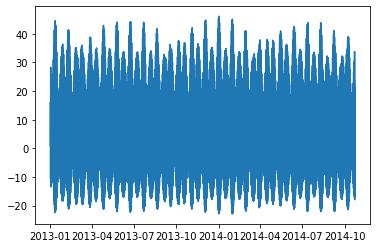

In [12]:
et=raw_data['Volume strain']
et=et[timestart:timeend]
plt.plot(df_gaps[dt_col],et)
output1 = hals.hals_lsq(df_detr.dnum.values, et-np.mean(et), list(freqs.values()))
et_detr=et-np.mean(et)
et_A = output1[0] #Amplitudes
et_phi = output1[1]*180/np.pi #Phases

In [13]:
output1

(array([ 0.76871086,  4.02180473,  0.30610959,  2.1887374 ,  0.04489105,
         6.00183109,  3.23205059, 16.62886709,  7.46775741,  1.62776001]),
 array([-1.90334056,  2.55910322,  0.61959862, -1.91882982, -0.17128732,
        -1.44792184,  1.40868906, -0.41044731,  1.2250878 , -1.31479043]),
 1.424102468410983,
 array([-7.26596913e-01, -2.50944841e-01,  2.21241309e+00, -3.35859220e+00,
         1.77760420e-01,  2.49207369e-01, -2.05751210e+00, -7.46468601e-01,
        -7.65172332e-03,  4.42341235e-02, -5.95657983e+00,  7.35617571e-01,
         3.18967636e+00,  5.21647172e-01, -6.63524268e+00,  1.52477138e+01,
         7.02593198e+00,  2.53054947e+00, -1.57470980e+00,  4.12179201e-01,
        -6.93614208e-04]),
 array([-4.35320482,  3.90015554,  9.83820029, ..., -3.09302304,
         7.11220934, 14.56109561]))

In [14]:
et_phi

array([-109.05338132,  146.62581397,   35.50038568, -109.94085056,
         -9.81404037,  -82.95981052,   80.71193751,  -23.51689868,
         70.19236021,  -75.33194232])

In [15]:
df_phi.loc['M2',gw_col]-et_phi[7]

J6 [m]   -17.507540
J7 [m]     3.436684
JC [m]   -13.355532
Name: M2, dtype: float64

In [16]:
J6_gw=df_detr.iloc[:,1]
J7_gw=df_detr.iloc[:,2]
JC_gw=df_detr.iloc[:,3]

In [17]:
J6_output = hals.hals_lsq(df_detr.dnum.values[30*24:90*24], J6_gw.values[30*24:90*24], list(freqs.values()))
a6=J6_output[0]
print(a6)
a6_m2=[]
a6_m2.append(a6[7])
a6_m2
df_detr.dnum.values[2]


Conditioning number:  53.10906162342595
[0.00021517 0.00066578 0.00034106 0.00474488 0.00960948 0.00457778
 0.00067433 0.0032819  0.00571214 0.00032686]


0.08333333333333333

In [18]:
datestamp=[]
J6_gwamp=[]
J6_gwampstd=[]
J6_gwpha=[]
J6_gwphastd=[]
J7_gwamp=[]
J7_gwampstd=[]
J7_gwpha=[]
J7_gwphastd=[]
JC_gwamp=[]
JC_gwampstd=[]
JC_gwpha=[]
JC_gwphastd=[]
ET_amp=[]
ET_pha=[]
a=0;b=60*24
while b<timeend:

    J6_output = hals.hals_lsq(df_detr.dnum.values[a:b], J6_gw.values[a:b], list(freqs.values()))
    J7_output = hals.hals_lsq(df_detr.dnum.values[a:b], J7_gw.values[a:b], list(freqs.values()))
    JC_output = hals.hals_lsq(df_detr.dnum.values[a:b], JC_gw.values[a:b], list(freqs.values()))
    ET_output = hals.hals_lsq(df_detr.dnum.values[a:b], et_detr[a:b], list(freqs.values()))
    J6_amp=J6_output[0]
    J6_pha=J6_output[1]
    J6_ampstd=J6_output[2] #I'm not sure those are  error
    J6_phastd=J6_output[3]
    J7_amp=J7_output[0]
    J7_pha=J7_output[1]
    J7_ampstd=J7_output[2]
    J7_phastd=J7_output[3]
    JC_amp=JC_output[0]
    JC_pha=JC_output[1]
    JC_ampstd=JC_output[2]
    JC_phastd=JC_output[3]
    et_amp=ET_output[0]
    et_pha=ET_output[1]
   
    datestamp.append(raw_data[dt_col][round((a+b)/2)])
    #extract M2
    J6_gwamp.append(J6_amp[7]) 
    #J6_gwampstd.append(J6_ampstd[7]) 
    J6_gwpha.append(J6_pha[7])
    #J6_gwphastd.append(J6_phastd[7])
    J7_gwamp.append(J7_amp[7]) 
    #J7_gwampstd.append(J7_ampstd[7]) 
    J7_gwpha.append(J7_pha[7])
    #J7_gwphastd.append(J7_phastd[7])
    JC_gwamp.append(JC_amp[7]) 
    #JC_gwampstd.append(JC_ampstd[7]) 
    JC_gwpha.append(JC_pha[7])
    #JC_gwphastd.append(JC_phastd[7])
    ET_amp.append(et_amp[7])
    ET_pha.append(et_pha[7])
    a+=5*24
    b+=5*24

Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.1090616234256
Conditioning number:  53.1090616234256
Conditioning number:  53.1090616234256
Conditioning number:  53.1090616234256
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425866
Conditioning number:  53.109061623425866
Conditioning number:  53.109061623425866
Conditioning number:  53.109061623425866
Conditioning number:  53.10906162342611
Conditioning number:  53.10906162342611
Conditioning number:  53.10906162342611
Conditioning number:  53.10906162342611
Conditioning number:  53.109061623425994
Conditioning number:  53.109061623425994
Conditioning number:  53.109061623425994
Conditioning number:  53.109061623425994
Conditioning number:  53.1090616

Conditioning number:  53.10906162342548
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559
Conditioning number:  53.10906162342559


Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552
Conditioning number:  53.10906162342552


In [19]:
def pi_range(value):
    value = np.array(value)
    idx = (value > 180)
    value[idx] -= 360
    idx = (value < -180)
    value[idx] += 360
    return value

In [20]:
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8,
}

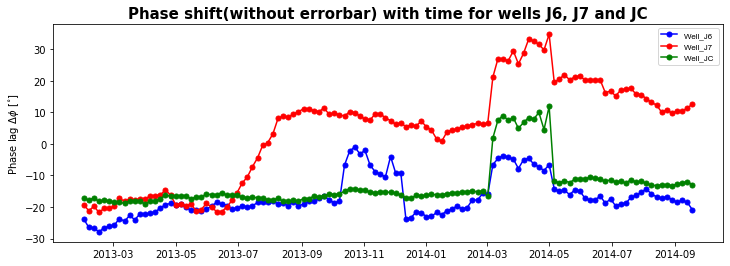

In [21]:
Date=np.asarray(datestamp)
J6_Ps=(pi_range(np.asarray(J6_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
J7_Ps=(pi_range(np.asarray(J7_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
JC_Ps=(pi_range(np.asarray(JC_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
fig=plt.figure(figsize=(12, 4))
ax=fig.add_subplot(111)
ax.set_title('Phase shift(without errorbar) with time for wells J6, J7 and JC',fontsize=15, fontweight='bold')
ax.plot(Date,J6_Ps, 'b.-', ms=10,label='Well_J6 ')
ax.plot(Date,J7_Ps, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,JC_Ps, 'g.-', ms=10,label='Well_JC ')
ax.set_ylabel("Phase shift $\Delta \phi$ ($^{\circ}$)",fontsize=10)

#ax.axvline(x=Date[29],ls="--",c="#E3072A")

#There may be some mistakes in the previous results, please check this one
ax.legend(prop=font1)
fig.savefig('202303wellJCJ6JCP.svg',bbox_inches='tight')

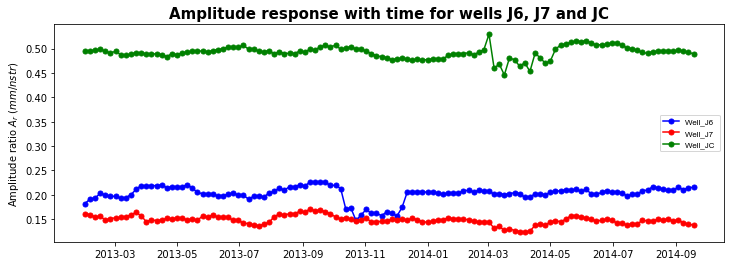

In [23]:
J6_Ar=np.asarray(J6_gwamp)/ np.asarray(ET_amp)*1e9
J7_Ar=np.asarray(J7_gwamp)/ np.asarray(ET_amp)*1e9
JC_Ar=np.asarray(JC_gwamp)/ np.asarray(ET_amp)*1e9
fig=plt.figure(figsize=(12, 4))
ax=fig.add_subplot(111)
ax.set_title('Amplitude response with time for wells J6, J7 and JC',fontsize=15, fontweight='bold')
ax.plot(Date,J6_Ar*1e-6, 'b.-', ms=10,label='Well_J6 ')
ax.plot(Date,J7_Ar*1e-6, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,JC_Ar*1e-6, 'g.-', ms=10,label='Well_JC ')
ax.set_ylabel("Amplitude ratio $A_r$ ($mm/nstr$)",fontsize=10)
ax.legend(prop=font1)
fig.savefig('202303wellJCJ6JCA.svg',bbox_inches='tight')

In [123]:
VJ7_Ps = list(filter(lambda x: x > 0, J7_Ps))
HJ7_Ps = list(filter(lambda x: x < 0, J7_Ps))
VJ7_Ps=np.asarray(VJ7_Ps)
HJ7_Ps=np.asarray(HJ7_Ps)
HJ7_Ar=J7_Ar[0:len(HJ7_Ps)]
VJ7_Ar=J7_Ar[len(HJ7_Ps):]
#print(VJ7_Ps)
#print(len(HJ7_Ps))
# VJC_Ps = list(filter(lambda x: x > 0, JC_Ps))
# HJC_Ps = list(filter(lambda x: x < 0, JC_Ps))
# VJC_Ps=np.asarray(VJC_Ps)
# HJC_Ps=np.asarray(HJC_Ps)
negative_indices = [i for i, x in enumerate(JC_Ps) if x > 0]
#print(negative_indices)
VJC_Ps=JC_Ps[negative_indices[0]:negative_indices[len(negative_indices)-1]+1]
VJC_Ar=JC_Ar[negative_indices[0]:negative_indices[len(negative_indices)-1]+1]
#print(VJ7_Ps)
HJC_Ps1=JC_Ps[0:negative_indices[0]]
HJC_Ar1=JC_Ar[0:negative_indices[0]]
HJC_Ps2=JC_Ps[negative_indices[len(negative_indices)-1]+1:]
HJC_Ar2=JC_Ar[negative_indices[len(negative_indices)-1]+1:]
#print(VJC_Ps)

In [98]:
freq = 1.932274

global Ker, Kei, power, sqrt
Ker = np.frompyfunc(mp.ker, 2, 1)
Kei = np.frompyfunc(mp.kei, 2, 1)
power = np.frompyfunc(mp.power, 2, 1)
sqrt = np.frompyfunc(mp.sqrt, 1, 1)
# the horizontal flow / negative phase model
def et_hflow(K, S_s, r_w=0.1, r_c=0.1, b=2, f=freq):
    global Ker, Kei, power, sqrt
    # create numpy function from mpmath
    # https://stackoverflow.com/questions/51971328/how-to-evaluate-a-numpy-array-inside-an-mpmath-fuction
    D_h = K / S_s
    omega = 2*np.pi*freq
    tmp = omega / D_h
    # prevent errors from negative square roots
    if (tmp >= 0):
        T = K*b
        sqrt_of_2 = sqrt(2)
        alpha_w = r_w * sqrt(tmp)
        ker_0_alpha_w = Ker(0, alpha_w)
        ker_1_alpha_w = Ker(1, alpha_w)
        kei_0_alpha_w = Kei(0, alpha_w)
        kei_1_alpha_w = Kei(1, alpha_w)
        denom = power(ker_1_alpha_w, 2) + power(kei_1_alpha_w, 2)
        Psi = - (ker_1_alpha_w - kei_1_alpha_w) / (sqrt_of_2 * alpha_w * denom)
        Phi = - (ker_1_alpha_w + kei_1_alpha_w) / (sqrt_of_2 * alpha_w * denom)
        E = np.float64(1 - (((omega*power(r_c, 2))/(2*T)) * (Psi*ker_0_alpha_w + Phi*kei_0_alpha_w)))
        F = np.float64((((omega*power(r_c,2))/(2*T)) * (Phi*ker_0_alpha_w - Psi*kei_0_alpha_w)))
        Ar = (E**2 + F**2)**(-0.5)
        dPhi = -np.arctan(F/E)
        return Ar, dPhi
    else:
        return np.Inf, np.Inf

def fit_amp_phase(props, amp, phase, r_c, r_w, scr_len, freq):
    #print(props)
    K, S_s = props
    Ar, dPhi = et_hflow(K, S_s, r_c, r_w, scr_len, freq)
    res_amp = amp*S_s - Ar
    res_phase = phase - dPhi
    error = np.asarray([res_amp,res_phase])
#    print(error)
    return error

In [99]:
from scipy.special import kv
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import loguniform

# Properties of the aquifer
freq = 1.932274 # Frequency in days
R_W = 0.15
R_C = 0.15
R = 0.2 # distance from the well m (only for drawdown computation)
B_AQ = 1 # Aquifer depth m
B_LE = 100 # Leaky layer depth m
SKEMPTON = 0.5 # Skempton's coefficient [-]
BULK = 20000000000.0 

def et_vflow(K_AQ, S_AQ, K_LE, R_C, R_W, B_AQ, B_LE, freq):
    omega = 2 * np.pi * freq
    betta = ((K_LE / (K_AQ * B_AQ * B_LE)) + ((1j * omega * S_AQ * B_AQ) / (K_AQ * B_AQ))) ** 0.5
    argument = (1j * omega * S_AQ * B_AQ) / (1j * omega * S_AQ * B_AQ + K_LE / B_LE)
    xi = 1 + ((1j * omega * R_W) / (2 * K_AQ * B_AQ * betta)) * (kv(0, betta * R_W) / kv(1, betta * R_W)) * (R_C / R_W)**2
    # water level
    h_w = argument / xi
    return np.abs(h_w), np.angle(h_w, deg=True)
#%%

def Vfit_amp_phase(vars):
    K_AQ, S_AQ, K_LE = vars
    Ar, dPhi = et_vflow(K_AQ, S_AQ, K_LE, R_C, R_W, B_AQ, B_LE, freq)
    res_amp = amp - Ar
    res_phase = phase - dPhi
    error = np.asarray([res_amp, res_phase])
    return error

In [100]:
from scipy.optimize import least_squares

r_c=0.15
r_w=0.15
scr_len=1
J6K_list = []
J6Ss_list = []
for b in range(len(J6_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = J6_Ar[b]
    phase = J6_Ps[b]*np.pi/180
    # least squares fitting
    fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    J6K_list.append(K)
    Ss = fit.x[1]
    J6Ss_list.append(Ss)

-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------


In [101]:
HJ7K_list = []
HJ7Ss_list = []
for i in range(len(HJ7_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = HJ7_Ar[i]
    phase = HJ7_Ps[i]*np.pi/180
    # least squares fitting
    fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    HJ7K_list.append(K)
    Ss = fit.x[1]
    HJ7Ss_list.append(Ss)

In [102]:
##Estimate the part of J7 phase greater than 0
VJ7K_list = []
VJ7Ss_list = []
for i in range(len(VJ7_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = VJ7_Ar[i]*1e-6
    phase = VJ7_Ps[i]
    # least squares fitting
    fit =  least_squares(Vfit_amp_phase, [1E-7*24*3600, 1E-5, 1E-11*24*3600], bounds=([1e-10*24*3600,1e-10, 1E-16*24*3600], [1e-2*24*3600,1e-3,1E-2*24*3600]), xtol=3e-16, ftol=3e-16, gtol=3e-16)
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    VJ7K_list.append(K)
    Ss = fit.x[1]
    VJ7Ss_list.append(Ss)

In [103]:
J7K=(HJ7K_list)+(VJ7K_list)


In [124]:
JCK1_list = []
JCSs1_list = []
for i in range(len(HJC_Ps1)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = HJC_Ar1[i]
    phase = HJC_Ps1[i]*np.pi/180
    # least squares fitting
    fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    JCK1_list.append(K)
    Ss = fit.x[1]
    JCSs1_list.append(Ss)

In [125]:
JCK2_list = []
JCSs2_list = []
for i in range(len(HJC_Ps2)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = HJC_Ar2[i]
    phase = HJC_Ps2[i]*np.pi/180
    # least squares fitting
    fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    JCK2_list.append(K)
    Ss = fit.x[1]
    JCSs2_list.append(Ss)

In [126]:
##Estimate the part of J7 phase greater than 0
VJCK_list = []
VJCSs_list = []
for i in range(len(VJC_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = VJC_Ar[i]*1e-6
    phase = VJC_Ps[i]
    # least squares fitting
    fit =  least_squares(Vfit_amp_phase, [1E-7*24*3600, 1E-5, 1E-11*24*3600], bounds=([1e-10*24*3600,1e-10, 1E-16*24*3600], [1e-2*24*3600,1e-3,1E-2*24*3600]), xtol=3e-16, ftol=3e-16, gtol=3e-16)
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    VJCK_list.append(K)
    Ss = fit.x[1]
    VJCSs_list.append(Ss)

In [127]:
JCK=JCK1_list+VJCK_list+JCK2_list

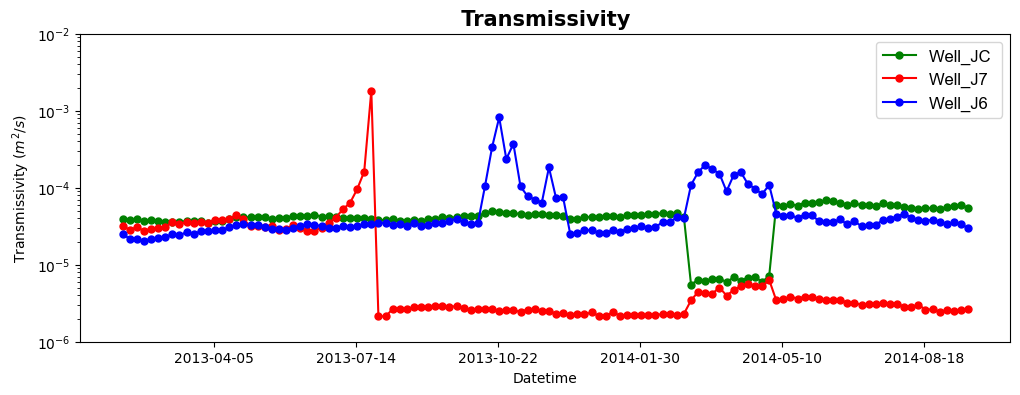

In [155]:
J6T=np.asarray(J6K_list)*1
J7T=np.asarray(J7K)*1
JCT=np.asarray(JCK)*1
fig=plt.figure(figsize=(12, 4))
from matplotlib.ticker import MultipleLocator
ax=fig.add_subplot(111)
ax.set_title(' Transmissivity ',fontsize=15, fontweight='bold')
ax.plot(Date,JCT, 'g.-', ms=10,label='Well_JC ')
ax.plot(Date,J7T, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,J6T, 'b.-', ms=10,label='Well_J6 ')



ax.set_ylabel("Transmissivity $(m^2/s)$",fontsize=10)
ax.set_xlabel("Datetime",fontsize=10)
ax.set_ylim([1e-6, 1e-2])
ax.set_yscale("log")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=100)) # 解决X轴密集问题
ax.legend(prop=font1)

fig.savefig('202303wellJCJ6JCT.svg',bbox_inches='tight')

In [130]:
JCW=raw_data['JC [m]']
J7W=raw_data['J7 [m]']
J6W=raw_data['J6 [m]']

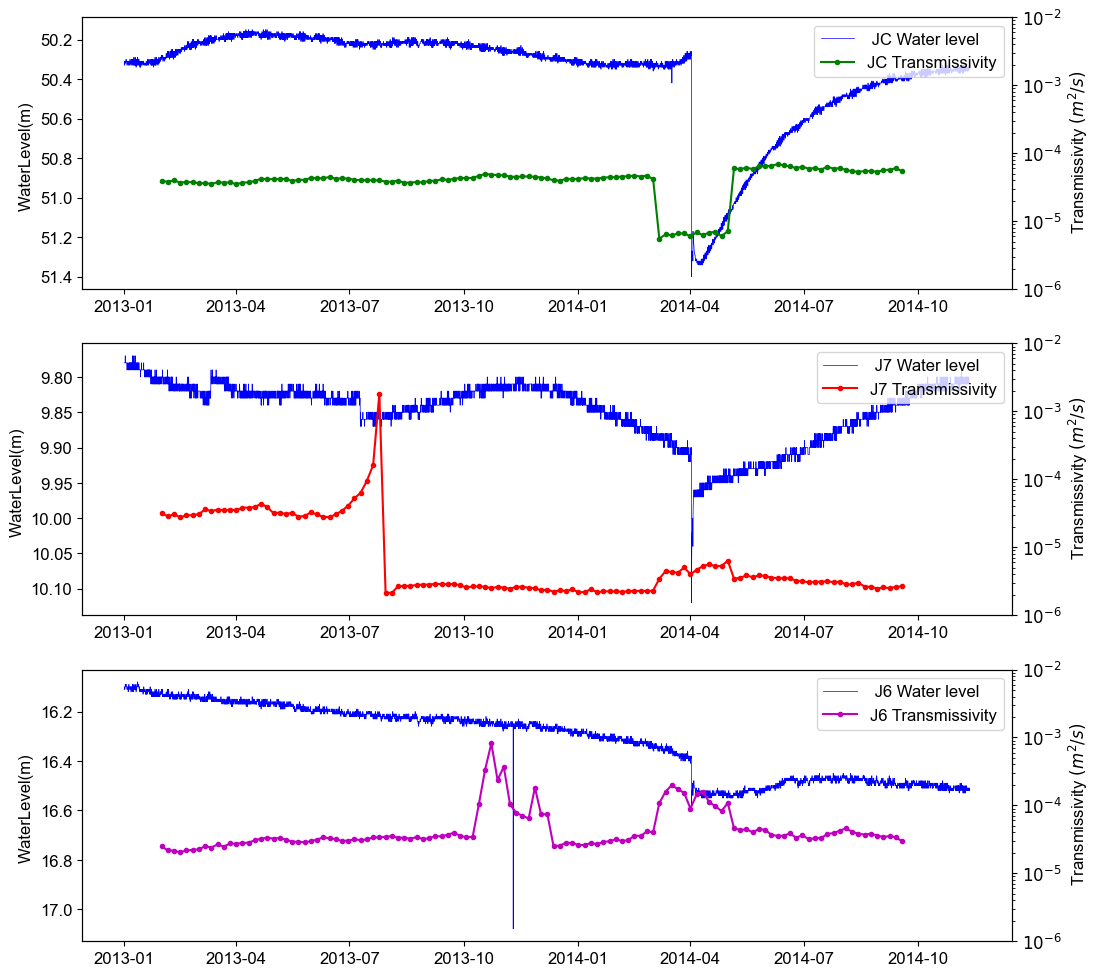

In [156]:
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 12,
}
fig1=plt.figure(figsize=(12,12))
ax1 = fig1.add_subplot(311)
lns1 = ax1.plot(raw_data[dt_col],JCW, c='b',lw=0.5,label=' JC Water level')
ax1.set_ylabel('WaterLevel(m) ',font1)
ax1.invert_yaxis()
ax1.legend(loc=2,prop=font1)
ax2=ax1.twinx()
lns2 = ax2.plot(Date,JCT,'g.-',label='JC Transmissivity')
ax2.set_ylabel(' Transmissivity $(m^2/s)$',font1)
ax2.set_ylim([1e-6, 1e-2])
ax2.set_yscale("log")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,prop=font1)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

ax1 = fig1.add_subplot(312)
lns1 = ax1.plot(raw_data[dt_col],J7W, c='b',lw=0.5,label=' J7 Water level')
ax1.set_ylabel('WaterLevel(m) ',font1)
ax1.invert_yaxis()
ax1.legend(loc=2,prop=font1)
ax2=ax1.twinx()
lns2 = ax2.plot(Date,J7T,'r.-',label='J7 Transmissivity')
ax2.set_ylabel(' Transmissivity $(m^2/s)$',font1)
ax2.set_ylim([1e-6, 1e-2])
ax2.set_yscale("log")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,prop=font1)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

ax1 = fig1.add_subplot(313)
lns1 = ax1.plot(raw_data[dt_col],J6W, c='b',lw=0.5,label=' J6 Water level')
ax1.set_ylabel('WaterLevel(m) ',font1)
ax1.invert_yaxis()
ax1.legend(loc=2,prop=font1)
ax2=ax1.twinx()
lns2 = ax2.plot(Date,J6T,'m.-',label='J6 Transmissivity')
ax2.set_ylabel(' Transmissivity $(m^2/s)$',font1)
ax2.set_ylim([1e-6, 1e-2])
ax2.set_yscale("log")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,prop=font1)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

fig1.savefig('202303wellJCJ6JCC.svg',bbox_inches='tight')